# KOH Posterior Analysis using Mici

In [3]:
from jax import config
config.update("jax_enable_x64", True)

import arviz
import gpjax as gpx
import jax
import jax.numpy as jnp
import kohgpjax as kgx
from kohgpjax.kohmodel import KOHModel
from kohgpjax.parameters import (
    ParameterPrior,
    ModelParameterPriorDict,
    ModelParameters,
)
import matplotlib.pyplot as plt
import mici
import numpy as np
import numpyro.distributions as dist

print("GPJax version:", gpx.__version__)
print("KOHGPJax version:", kgx.__version__)
print("JAX Device:", jax.devices())

from plotting import (
    plot_f_eta,
    plot_f_delta,
    plot_f_zeta,
    plot_pairwise_samples,
    plot_posterior_chains_with_priors,
    plot_sim_sample,
)

GPJax version: 0.11.1
KOHGPJax version: 0.4.0
JAX Device: [CpuDevice(id=0)]


In [4]:
from data.true_funcs import (
    discrepancy,
    eta,
    TrueParams,
    zeta,
)
TP = TrueParams()

Obviously neither `discrepancy()` nor `zeta()` are known is practice. This is only defined for demonstration purposes.

# The data

In [5]:
DATAFIELD = np.loadtxt('data/obs-ab.csv', delimiter=',', dtype=np.float32)
DATACOMP = np.loadtxt('data/sim-ab.csv', delimiter=',', dtype=np.float32)

yf = jnp.reshape(DATAFIELD[:, 0], (-1,1)).astype(jnp.float64)
yc = jnp.reshape(DATACOMP[:, 0], (-1,1)).astype(jnp.float64)
xf = jnp.reshape(DATAFIELD[:, 1], (-1, 1)).astype(jnp.float64)
xc = jnp.reshape(DATACOMP[:, 1], (-1,1)).astype(jnp.float64)
tc = jnp.reshape(DATACOMP[:, 2:], (-1,2)).astype(jnp.float64)

# normalising the output is not required provided they are all of a similar scale.
# But subtracting the mean is sensible as our GP priors assume zero mean.
ycmean = jnp.mean(yc)
yc_centered = yc - ycmean # Centre so that E[yc] = 0
yf_centered = yf - ycmean

# normalising the inputs is not required provided they are all of a similar scale.

tmin = jnp.min(tc, axis=0)
tmax = jnp.max(tc, axis=0)
print(f"tmin: {tmin}, tmax: {tmax}")
tc_normalized = (tc - tmin)/(tmax - tmin) # Normalize to [0, 1]

tminmax = {
    'theta_0': (tmin[0], tmax[0]),
    'theta_1': (tmin[1], tmax[1]),
}

field_dataset = gpx.Dataset(xf, yf_centered)
comp_dataset = gpx.Dataset(jnp.hstack((xc, tc_normalized)), yc_centered)

kohdataset = kgx.KOHDataset(field_dataset, comp_dataset)
print(kohdataset)

tmin: [ 0.25340652 -3.29292417], tmax: [ 0.4487448  -3.00703931]
KOHDataset(
  Datasets:
    Field data = Dataset(Number of observations: 100 - Input dimension: 1),
    Simulation data = Dataset(Number of observations: 1000 - Input dimension: 3)
  Attributes:
    No. field observations = 100,
    No. simulation outputs = 1000,
    No. variable params = 1,
    No. calibration params = 2,
)


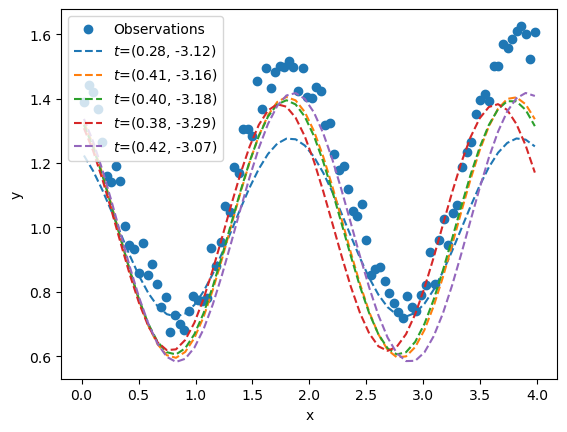

In [6]:
fig, ax = plot_sim_sample(
        xf=xf,
        yf=yf,
        xc=xc,
        yc=yc,
        tc=tc,
    )

# The Model

In [8]:
class Model(KOHModel):
    def k_eta(self, params_constrained) -> gpx.kernels.AbstractKernel:
        params = params_constrained['eta']
        return gpx.kernels.ProductKernel(
            kernels=[
                gpx.kernels.RBF(
                    active_dims=[0],
                    lengthscale=jnp.array(params['lengthscales']['x_0']),
                    variance=jnp.array(1/params['variances']['precision'])
                ), 
                gpx.kernels.RBF(
                    active_dims=[1],
                    lengthscale=jnp.array(params['lengthscales']['theta_0']),
                ),
                gpx.kernels.RBF(
                    active_dims=[2],
                    lengthscale=jnp.array(params['lengthscales']['theta_1']),
                ),
            ]
        )
    
    def k_delta(self, params_constrained) -> gpx.kernels.AbstractKernel:
        params = params_constrained['delta']
        return gpx.kernels.RBF(
                active_dims=[0],
                lengthscale=jnp.array(params['lengthscales']['x_0']),
                variance=jnp.array(1/params['variances']['precision'])
            )
    
    def k_epsilon(self, params_constrained) -> gpx.kernels.AbstractKernel:
        params = params_constrained['epsilon']
        return gpx.kernels.White(
                active_dims=[0],
                variance=jnp.array(1/params['variances']['precision'])
            )

In [ ]:
# account for the scaling onto [0, 1]
A0 = (0.25 - tmin[0])/(tmax[0] - tmin[0])
B0 = (0.45 - tmin[0])/(tmax[0] - tmin[0])
print(f"A0: {A0}, B0: {B0}")
A1 = (-3.3 - tmin[1])/(tmax[1] - tmin[1])
B1 = (-3.0 - tmin[1])/(tmax[1] - tmin[1])
print(f"A1: {A1}, B1: {B1}")
prior_dict: ModelParameterPriorDict = {
    'thetas': {
        'theta_0': ParameterPrior(
            dist.Uniform(low=A0, high=B0),
            name='theta_0',
        ),
        'theta_1': ParameterPrior(
            dist.Uniform(low=A1, high=B1),
            name='theta_1',
        ),
    },
    'eta': {
        'variances': {
                'precision': ParameterPrior(
                dist.Gamma(concentration=2.0, rate=4.0),
                name='eta_precision',
            ),
        },
        'lengthscales': {
            'x_0': ParameterPrior(
                dist.Gamma(concentration=4.0, rate=1.4),
                name='eta_lengthscale_x_0',
            ),
            'theta_0': ParameterPrior(
                dist.Gamma(concentration=2.0, rate=3.5),
                name='eta_lengthscale_theta_0',
            ),
            'theta_1': ParameterPrior(
                dist.Gamma(concentration=2.0, rate=3.5),
                name='eta_lengthscale_theta_1',
            ),
        },
    },
    'delta': {
        'variances': {
            'precision': ParameterPrior(
                dist.Gamma(concentration=2.0, rate=0.1),
                name='delta_precision',
            ),
        },
        'lengthscales': {
            'x_0': ParameterPrior(
                # dist.Gamma(concentration=4.0, rate=2.0),
                dist.Gamma(concentration=5.0, rate=0.3), # encourage long value => linear discrepancy
                name='delta_lengthscale_x_0',
            ),
        },
    },
    'epsilon': { # This is required despite not appearing in the model
        'variances': {
            'precision': ParameterPrior(
                # dist.Gamma(concentration=12.0, rate=0.025),
                dist.Normal(loc=420.0, scale=10.0), # Much more concentrated
                name='epsilon_precision',
            ),
        },
    },
}

model_parameters = ModelParameters(
    prior_dict=prior_dict
)

A0: -0.017439104488314455, B0: 1.0064257570984054
A1: -0.02475064382263792, B1: 1.0246228800555088


# MCMC Setup

In [10]:
model = Model(
    model_parameters=model_parameters,
    kohdataset=kohdataset,
)

The jax backend here will jit and grad the nlpd function we provide.

In [11]:
##### Mici #####
system = mici.systems.EuclideanMetricSystem(
    neg_log_dens=model.get_KOH_neg_log_pos_dens_func(),
    backend="jax",
)
integrator = mici.integrators.LeapfrogIntegrator(system)

In [12]:
prior_leaves, prior_tree = jax.tree.flatten(prior_dict)
prior_means = jax.tree.map(
    lambda x: x.inverse(x.distribution.mean), prior_leaves
)

init_states = np.array(prior_means) # NOT jnp.array
print(f"Initial states: {init_states}")

Initial states: [ 0.69314718  2.99573227  6.1737861  -0.55961579 -0.55961579  1.04982212
 -0.69314718  0.          0.        ]


In [13]:
f = model.get_KOH_neg_log_pos_dens_func()
f(init_states)

Array(1860421.28405486, dtype=float64)

# Running MCMC algorithm

First, build the tracer function to get the chains for each parameter. We need to know the ordering of the parameter when jax flattens the pytree. This ordering is easiest obtained if we assign names to the parameters priors. We can simply extract the parameter name and index by iterating through the priors_flat list.

In [14]:
tracer_index_dict = {}
for i, prior in enumerate(model_parameters.priors_flat):
    tracer_index_dict[prior.name] = i
# print(tracer_index_dict)

In [15]:
seed = 1234
n_chain = 2
n_process = 1 # only 1 works on MacOS
n_warm_up_iter = 50
n_main_iter = 50
rng = np.random.default_rng(seed)

##### Mici sampler and adapters #####
# sampler = mici.samplers.StaticMetropolisHMC(system, integrator, rng, n_step=3)
sampler = mici.samplers.DynamicMultinomialHMC(system, integrator, rng, max_tree_depth=5)
adapters = [
    mici.adapters.DualAveragingStepSizeAdapter(0.8),
    mici.adapters.OnlineCovarianceMetricAdapter()
]

def trace_func(state):
    trace = {
        key: state.pos[index] for key, index in tracer_index_dict.items()
    }
    trace['hamiltonian'] = system.h(state)
    return trace

final_states, traces, stats = sampler.sample_chains(
    n_warm_up_iter, 
    n_main_iter, 
    [init_states] * n_chain, 
    adapters=adapters, 
    n_process=n_process, 
    trace_funcs=[trace_func],
    monitor_stats=("n_step", "accept_stat", "step_size", "diverging")
)

Sampling stage: Initial fast adaptive [01:06] > Slow adaptive (1/1) [09:06] > Final fast adaptive [01:04] > Main non-adaptive [16:25]

Chain 1/2: 100%|██████████|50/50 [07:53<00:00, 9.48s/it, n_step=30.4, accept_stat=0.957, step_size=0.0819, diverging=0.00]

Chain 2/2: 100%|██████████|50/50 [08:31<00:00, 10.23s/it, n_step=31.0, accept_stat=0.958, step_size=0.0819, diverging=0.00]

# Analyse MCMC output

In [16]:
arviz.summary(traces)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
delta_lengthscale_x_0,0.971,0.309,0.475,1.539,0.055,0.024,33.0,77.0,1.00
delta_precision,3.262,0.476,2.340,4.057,0.070,0.041,50.0,60.0,1.01
epsilon_precision,6.262,0.120,6.057,6.506,0.014,0.008,76.0,80.0,1.03
eta_lengthscale_theta_0,1.400,0.090,1.260,1.573,0.011,0.006,69.0,58.0,1.00
eta_lengthscale_theta_1,0.545,0.063,0.433,0.663,0.006,0.004,106.0,103.0,1.01
eta_lengthscale_x_0,-0.296,0.037,-0.368,-0.228,0.003,0.003,138.0,69.0,1.02
eta_precision,0.213,0.243,-0.182,0.673,0.033,0.017,57.0,72.0,0.99
hamiltonian,-5725.278,2.911,-5730.160,-5720.245,0.573,0.202,25.0,76.0,1.04
theta_0,0.952,0.148,0.690,1.220,0.022,0.013,44.0,41.0,1.00
theta_1,0.428,0.122,0.235,0.724,0.013,0.009,87.0,120.0,1.00


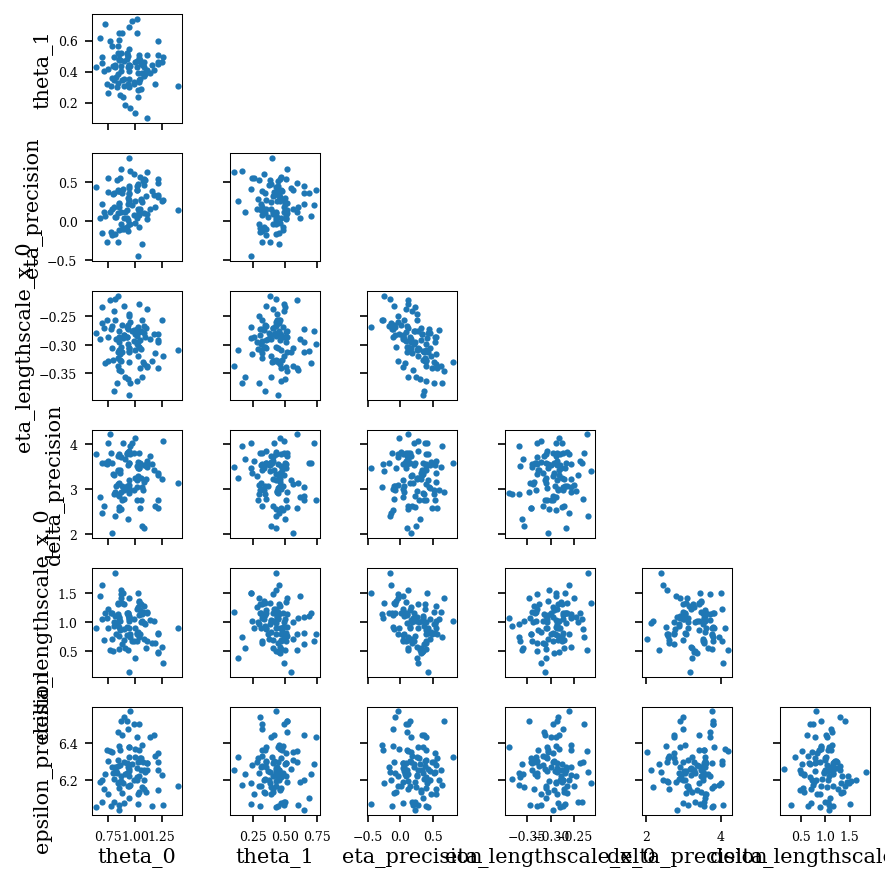

In [19]:
axes = plot_pairwise_samples(
        traces,
        var_names=[
            *(prior_dict["thetas"].keys()),
            "eta_precision",
            "eta_lengthscale_x_0",
            "delta_precision",
            "delta_lengthscale_x_0",
            "epsilon_precision",
        ],
    )

# Transform the Chains

In [21]:
traces_transformed = {}
for var, trace in traces.items():
    if var == 'hamiltonian':
        continue
    index = tracer_index_dict[var]
    traces_transformed[var] = model_parameters.priors_flat[index].forward(np.array(trace))
    if var in prior_dict["thetas"].keys():
        trace = traces_transformed[var]
        tmin, tmax = tminmax[var]
        traces_transformed[var] = list((jnp.array(trace) * (tmax - tmin)) + tmin)

params_transformed_flat = {}
for var, trace in traces_transformed.items():
    params_transformed_flat[var] = np.mean(trace) # This operation is valid across chains when each chain has equal length (I think).
    print(var, ": ", np.mean(trace), '±', np.std(trace))

params_transformed = jax.tree.unflatten(
    prior_tree,
    params_transformed_flat.values()
)

delta_lengthscale_x_0 :  2.7692053402982886 ± 0.870948397029615
delta_precision :  28.986489206975595 ± 12.91349078659185
epsilon_precision :  528.3179903893671 ± 64.83311529976352
eta_lengthscale_theta_0 :  4.0729084763333 ± 0.3679595557701204
eta_lengthscale_theta_1 :  1.7271899464164222 ± 0.10893327460327178
eta_lengthscale_x_0 :  0.7440195897566096 ± 0.027405001170496497
eta_precision :  1.2739237815342088 ± 0.30622776026223825
theta_0 :  0.39411984081962403 ± 0.005836758681496343
theta_1 :  -3.1185256509547243 ± 0.008644366862186992


In [22]:
arviz.summary(traces_transformed)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
delta_lengthscale_x_0,2.769,0.875,1.460,4.476,0.149,0.107,33.0,77.0,1.00
delta_precision,28.986,12.979,8.931,56.253,1.768,1.049,50.0,60.0,1.01
epsilon_precision,528.318,65.160,427.159,669.058,7.383,4.883,76.0,80.0,1.03
eta_lengthscale_theta_0,4.073,0.370,3.489,4.779,0.045,0.029,69.0,58.0,1.00
eta_lengthscale_theta_1,1.727,0.109,1.542,1.942,0.011,0.007,106.0,103.0,1.01
eta_lengthscale_x_0,0.744,0.028,0.692,0.796,0.002,0.002,138.0,69.0,1.02
eta_precision,1.274,0.308,0.749,1.826,0.040,0.022,57.0,72.0,0.99
theta_0,0.394,0.006,0.383,0.404,0.001,0.000,44.0,41.0,1.00
theta_1,-3.119,0.009,-3.132,-3.098,0.001,0.001,87.0,120.0,1.00


In [ ]:
arviz.convert_to_inference_data(traces).to_netcdf(f"chains/{file_name}-W{n_warm_up_iter}-N{n_main_iter}-raw.nc")
arviz.convert_to_inference_data(traces_transformed).to_netcdf(f"chains/{file_name}-W{n_warm_up_iter}-N{n_main_iter}.nc")


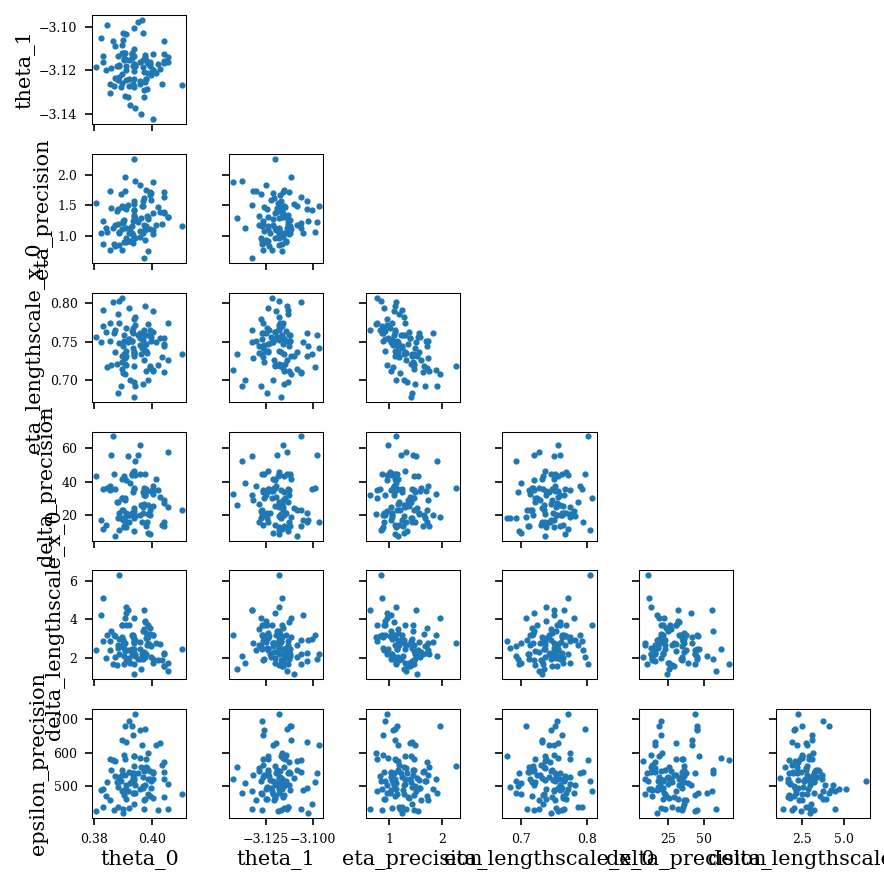

In [23]:
axes = plot_pairwise_samples(
        traces_transformed,
        var_names=[
            *(prior_dict["thetas"].keys()),
            "eta_precision",
            "eta_lengthscale_x_0",
            "delta_precision",
            "delta_lengthscale_x_0",
            "epsilon_precision",
        ],
    )

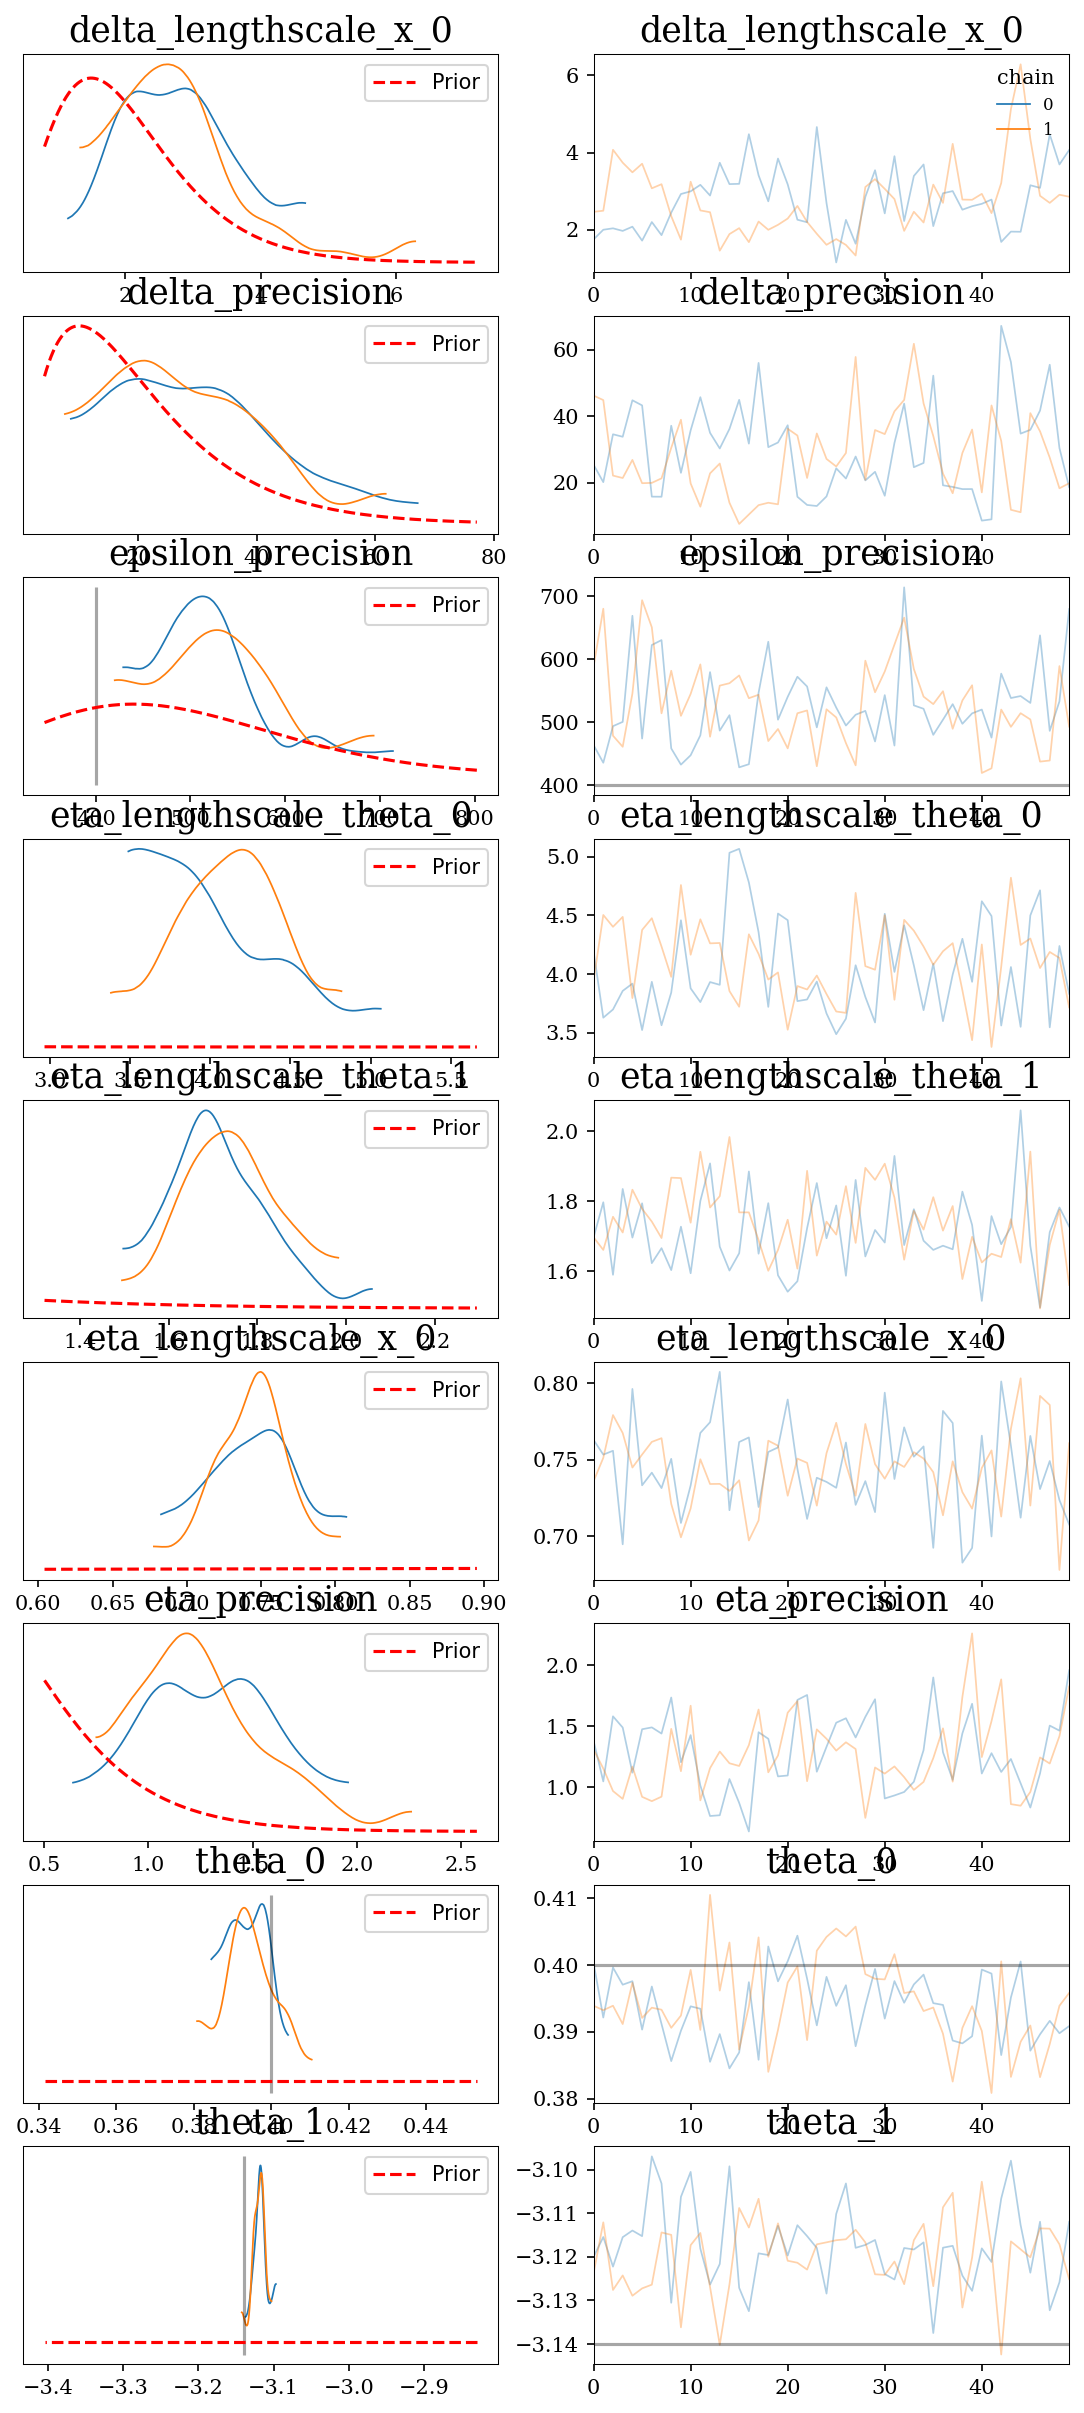

In [40]:
axes = plot_posterior_chains_with_priors(
        traces_transformed,
        model_parameters=model_parameters,
        tracer_index_dict=tracer_index_dict,
        true_values={
            "theta_0": TP.a,
            "theta_1": TP.b,
            "epsilon_precision": 1 / TP.obs_var,
        },
        figsize=(9, 20),
    )

# Analyse posterior fit

## Prediction data

In [41]:
x0_pred = np.linspace(0, 4, 1000)
x1_pred = np.zeros_like(x0_pred)
xpred = np.vstack((x0_pred, x1_pred)).T
print(xpred.shape)

thetas = np.array([params_transformed_flat[var] for var in prior_dict['thetas'].keys()])
theta_vec = jnp.array([thetas[0], thetas[1], TP.c, TP.d, TP.e])
theta_arr = jnp.tile(theta_vec, (xpred.shape[0], 1))
print(theta_arr.shape)

x_test = np.hstack((xpred, theta_arr))
print(x_test.shape)

x_test_GP = x_test[:, [0, 2, 3]]
print(x_test_GP.shape)

dataset = kohdataset.get_dataset(thetas.reshape(1,-1))
print(dataset)

(1000, 2)
(1000, 5)
(1000, 7)
(1000, 3)
Dataset(Number of observations: 1100 - Input dimension: 3)


## Posterior GPs

In [42]:
GP_posterior = model.GP_posterior(params_transformed)

eta_pred = GP_posterior.predict_eta(x_test_GP, dataset)
zeta_pred = GP_posterior.predict_zeta(x_test_GP, dataset)
obs_pred = GP_posterior.predict_obs(x_test_GP, dataset)

eta_pred_m = eta_pred.mean
eta_pred_cov = eta_pred.covariance_matrix

zeta_pred_m = zeta_pred.mean
zeta_pred_cov = zeta_pred.covariance_matrix

## Plot GP modelling simulator

In [43]:
fig, ax = plot_f_eta(
    x_full=x_test,
    x_GP=x_test_GP[:, 0],
    thetas=thetas,
    thetas_full=theta_arr,
    eta=eta,
    GP_eta=eta_pred,
    y_translation=ycmean, # translate back to original scale
)

TypeError: plot_f_eta() got an unexpected keyword argument 'y_translation'

## Plot GP modelling true process

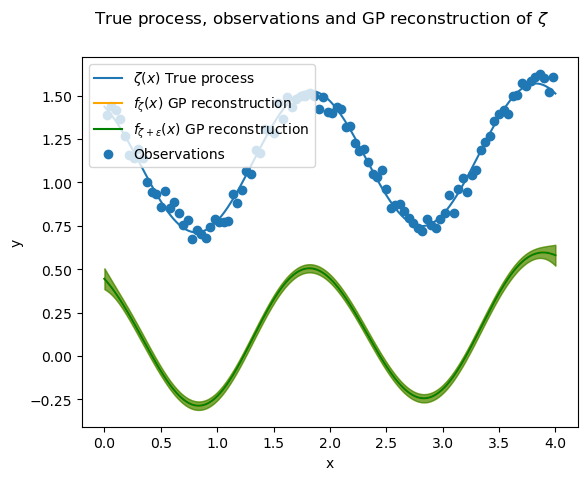

In [ ]:
fig, ax = plot_f_zeta(
    x_full=x_test,
    x_GP=x_test_GP[:, 0],
    zeta=zeta,
    GP_zeta=zeta_pred,
    GP_zeta_epsilon=obs_pred,
    scatter_xf=kohdataset.Xf,
    scatter_yf=kohdataset.z
    y_translation=ycmean, # translate back to original scale
)

## Model discrepancy

Interpret the next figure as follows. "True discrepancy" is the actual difference between the functions used to generate the simulation output and the observations. The blue line is the function the code is trying to learn. According to the MCMC samples, $\delta(x)$ should be the blue line. $f_\delta(x)$ is the attempt to learn the blue line.

Notice the uncertainty of the GP is very large and always encompases the true discrepancy function, $0$ for all $x$.

In [ ]:
delta_gp_m = zeta_pred_m - eta_pred_m
delta_gp_cov = zeta_pred_cov + eta_pred_cov

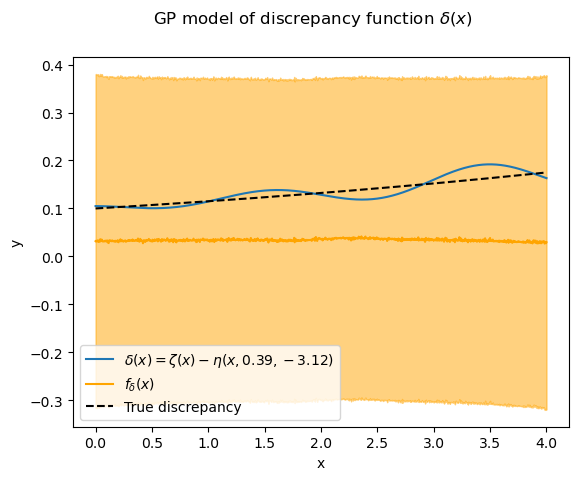

In [ ]:
fig, ax = plot_f_delta(
    x_full=x_test,
    x_GP=x_test_GP[:, 0],
    thetas=thetas,
    thetas_full=theta_arr,
    zeta=zeta,
    eta=eta,
    delta=discrepancy,
    delta_gp_mean=delta_gp_m,
    delta_gp_cov=delta_gp_cov,
)